# Demo 14 Spark

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Use conda to install graphviz and python-graphviz
import graphviz
import dask.array
# import dask.dataframe
from dask.dot import dot_graph

# What is Spark?

Spark is a general-purpose distributed data processing engine.

 - Powerful engine designed for distributive computing
 - Supporting multiple programming languages and libraries
 - Runs on top of hdfs and uses map reduce for batch jobs


# Why use Spark?


 - Lightning fast. Spark utilizes RAM instead of disk read to produce faster results.
 - Ability to schedule and bind tasks instead of running them one by one.
 - Simple to understand and less code to worry about.


# Spark Core: Resilient Distributed Dataset (RDD)

RDD is a representation of data located on a network which is

 - Immutable - You can operate on the RDD to produce another RDD but you can’t alter it.
 - Partitioned / Parallel - The data located on RDD is operated in parallel. Any operation on RDD is done using multiple nodes.
 - Resilience - If one of the node hosting the partition fails, another node takes its place.


# RDD Transformations

A: The transformations are the functions that are applied on an RDD (resilient distributed data set). The transformation results in another RDD. A transformation is not executed until an action follows.

The example of transformations are:
map(), filter(), groupByKey(), sortByKey(), etc.


# RDD Actions

A: An action brings back the data from the RDD to the local machine. Execution of an action results in all the previously created transformation. The example of actions are:
   count() ,take(n) ,collect(),saveAsTextFile(file), reduce()

# Install and Configure PySpark

First, install Spark.

In [2]:
!pip install findspark pyspark

     |████████████████████████████████| 194kB 20.0MB/s eta 0:00:01
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/share/apps/jupyterhub/2019-FA-DS-GA-1007/lib/python3.7/site-packages/findspark.py'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


Set up the PySpark environment.

In [ ]:
import findspark
import site

findspark.init(site.getsitepackages()[0] + "/pyspark")

Initialize the SparkSQL session which contains a basic Spark Context.  This may take a few moments to launch the cluster of (typically 4 to 8 python jobs in the background).  Note in a distributed Spark deployment you would change the `.master("local[*]")` to instead point to the YARN resource manager.  To learn more about deploying Spark on a cluster of machines read [this tutorial](https://spark.apache.org/docs/latest/cluster-overview.html).

Note: You must have Java installed on your computer for this to work!

In [ ]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("LectureExample")
        .getOrCreate()
)
sc = spark.sparkContext

# Using Spark

### Example 1: Processing Text

Let's use Spark to implement map / reduce for enumerating the occurrences of words in text documents.

In [ ]:
from IPython.display import Image

Image("image.PNG")
# to be or not to be mapping

Compare the approach to the split-appy-combine steps in grouping records from a table

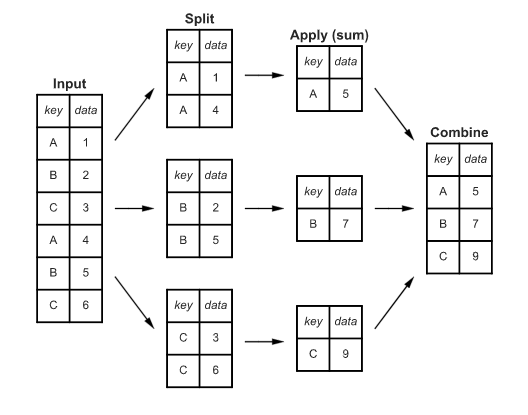

In [24]:
Image('img4.PNG')

In [ ]:
lines = sc.textFile("little_women.txt")

In [ ]:
# %%timeit
count = (  lines.flatMap(lambda line: line.split(" "))
                .map(lambda word: (word, 1))
                .reduceByKey(lambda x, y: x + y)  )

In [19]:
count.collect() # meg amy and beth

[('The', 336),
 ('Project', 78),
 ('Gutenberg', 21),
 ('EBook', 2),
 ('of', 3439),
 ('Little', 10),
 ('Women,', 2),
 ('by', 519),
 ('Louisa', 4),
 ('May', 20),
 ('Alcott', 4),
 ('This', 51),
 ('eBook', 5),
 ('is', 724),
 ('for', 2134),
 ('the', 7256),
 ('use', 52),
 ('anyone', 52),
 ('anywhere', 11),
 ('at', 1018),
 ('no', 380),
 ('cost', 16),
 ('and', 7872),
 ('with', 1800),
 ('almost', 30),
 ('restrictions', 2),
 ('whatsoever.', 2),
 ('You', 138),
 ('may', 124),
 ('copy', 14),
 ('it,', 365),
 ('give', 121),
 ('it', 1420),
 ('away', 184),
 ('or', 494),
 ('re-use', 2),
 ('under', 93),
 ('terms', 20),
 ('License', 8),
 ('included', 2),
 ('this', 329),
 ('online', 4),
 ('www.gutenberg.net', 2),
 ('Title:', 1),
 ('Women', 4),
 ('Author:', 1),
 ('Posting', 1),
 ('Date:', 2),
 ('September', 2),
 ('13,', 1),
 ('2008', 1),
 ('[EBook', 1),
 ('#514]', 1),
 ('Release', 1),
 ('May,', 7),
 ('1996', 1),
 ('[This', 1),
 ('file', 3),
 ('last', 107),
 ('updated', 1),
 ('on', 859),
 ('August', 1),
 ('1

#### Question: How can we filter out words not contained in a collection such as `['Meg','Amy','Beth']`

In [20]:
def check_inclusion(possible_entry, collection):
    return possible_entry in collection


collection = ['Meg','Amy','Beth']
count = (  lines.flatMap(lambda line: line.split(" "))
                .map(lambda word: (word, 1))
                .filter(lambda word_pair: check_inclusion(word_pair[0], collection) )
                .reduceByKey(lambda x, y: x + y)  )

In [21]:
count.collect()

[('Beth', 232), ('Meg', 384), ('Amy', 355)]

## Example 2: Resampling: Arrays in Spark

Let's use Spark to parallelize a simulation.

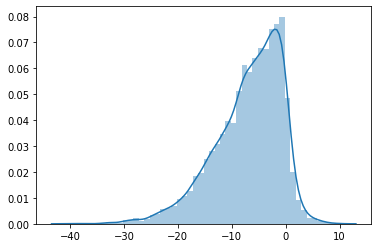

In [25]:
np.random.seed(42)

weird_data = np.random.randn(10000)**2 - 10 *np.abs( np.random.randn(10000) )
sns.distplot(weird_data);

In [4]:
def resample(data, seed):
    np.random.seed(seed)
    return data[np.random.randint(0, len(data),len(data))]

def bootstrap_mean(data, seed):
    return resample(data, seed).mean()

In [5]:
bootstrap_mean(weird_data, 43)

-6.969561755437433

We can set up a bunch of random seeds and compute bootstrap means for each.

In [6]:
seeds = np.arange(10000) + 42

In [7]:
samples_local = np.array([bootstrap_mean(weird_data, s) for s in seeds])

And the bootstrap distribution of the sample mean is:

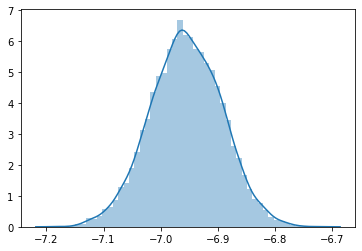

In [8]:
sns.distplot(samples_local);

Let's see how long computation of the sample means above took using the iPython `%%timeit` command, which will rerun the code 8 times and compute the average time needed.

In [17]:
%%timeit
samples_local = np.array([bootstrap_mean(weird_data, s) for s in seeds])

1.93 s ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see if we can do better by using Spark.

In [12]:
samples = (
    sc.parallelize(seeds)
        .map(lambda seed: bootstrap_mean(weird_data, seed))
)

In [14]:
samples.count()

10000

If we look at our samples, we should see the exact same distribution as in our non-parallel computation above.

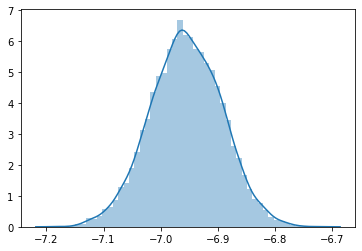

In [15]:
sns.distplot(samples.collect());

Since everything looks good, let's see how long it takes Spark. Do we see an improvement?

In [20]:
%%timeit
samples.mean()

97.6 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


One of the key innovations in Spark is the ability to cache computation. 

In [18]:
samples.persist()

PythonRDD[4] at collect at <ipython-input-15-3d26f573bd91>:1

Timing after warming the cache, and we see things are much much faster.

In [19]:
%%timeit 
samples.mean()

108 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Example 3 Basketball Statistics: Tables in Spark

In [27]:
nba = pd.read_csv('nba.csv')
nba.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22017,1610612744,GSW,Golden State Warriors,21700002,2017-10-17,GSW vs. HOU,L,240,43,...,35,41,34,5,9,17,25,121,-1,1
1,22017,1610612745,HOU,Houston Rockets,21700002,2017-10-17,HOU @ GSW,W,240,47,...,33,43,28,9,5,13,16,122,1,1
2,22017,1610612738,BOS,Boston Celtics,21700001,2017-10-17,BOS @ CLE,L,240,36,...,37,46,24,11,4,12,24,99,-3,1
3,22017,1610612739,CLE,Cleveland Cavaliers,21700001,2017-10-17,CLE vs. BOS,W,240,38,...,41,50,19,3,4,17,25,102,3,1
4,22017,1610612750,MIN,Minnesota Timberwolves,21700011,2017-10-18,MIN @ SAS,L,240,37,...,31,42,23,7,4,13,16,99,-8,1


In [28]:
sdf = spark.createDataFrame(nba)

Spark dataframes have a similar interface to Pandas dataframes.

In [25]:
%%timeit
sdf.where(sdf["TEAM_ABBREVIATION"] == 'GSW').count()

52 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


All operations are now cached!

In [26]:
%%timeit
sdf.where(sdf["TEAM_ABBREVIATION"] == 'GSW').count()

51.2 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


And you can use SQL if you prefer.

In [ ]:
sdf.registerTempTable("nba")

In [58]:
spark.sql("""
    SELECT   TEAM_ABBREVIATION, 
             AVG(CASE WHEN WL="W" THEN 1 ELSE 0 END) AS WIN_RATE
    FROM     nba 
    GROUP BY TEAM_ABBREVIATION
    ORDER BY -WIN_RATE 
""").toPandas()

,TEAM_ABBREVIATION,WIN_RATE
0,HOU,0.792683
1,TOR,0.719512
2,GSW,0.707317
3,BOS,0.670732
4,PHI,0.634146
5,CLE,0.609756
6,POR,0.597561
7,UTA,0.585366
8,OKC,0.585366
9,NOP,0.585366


# Question 

How many games were played by the Boston Celtics (BOS)? Try computing the answer in four ways using
 - pandas
 - Dask 
 - Spark 
   * pandas syntax  
   * SQL syntax
   

In [40]:
# pandas

nba_pivot_table = pd.pivot_table(nba, index='TEAM_NAME', columns='WL', values="GAME_ID", aggfunc='count' )

nba_pivot_table.loc['Boston Celtics','W']

55

In [ ]:
# Dask 

size_array = len(nba)
number_partitions = 5

dask_nba = dask.dataframe.from_pandas(nba,chunksize= size_array // number_partitions)

dask_nba_filtered = dask_nba[ (dask_nba['TEAM_ABBREVIATION'] == 'BOS') & (dask_nba['WL'] == 'W')]
count = dask_nba_filtered['GAME_ID'].count()
count.compute()

In [ ]:
dot_graph(count.dask)

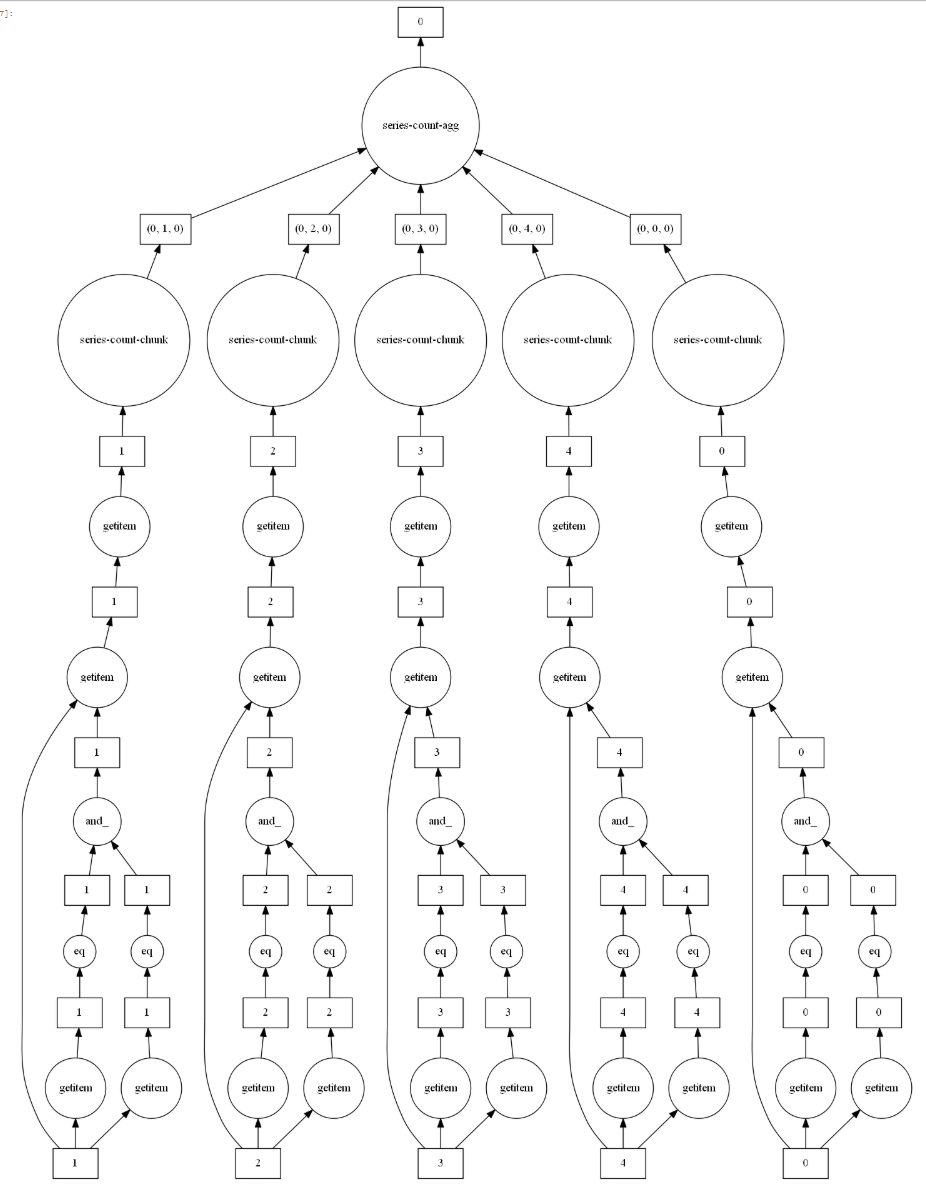

In [55]:
Image('dask.PNG')

In [56]:
# Spark pandas

sdf.where((sdf['TEAM_ABBREVIATION'] == 'BOS') & (sdf['WL'] == 'W')).count()

55

In [61]:
# Spark SQL

spark.sql("""
SELECT COUNT(DISTINCT GAME_ID) 
FROM nba
WHERE WL='W' AND TEAM_ABBREVIATION='BOS'
"""
).toPandas()

,count(DISTINCT GAME_ID)
0,55
